In [1]:
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

Mounted at /content/drive


In [2]:
# Import libraries
import numpy as np
import math
import numbers
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import matplotlib.lines
%matplotlib inline

import torch
from torch import Tensor
from torch import nn
import torch.nn.functional as F
from torch import optim
from torch.utils.data import TensorDataset
from torch.utils.data import DataLoader
from torch.autograd import Variable
from torchvision.models import vgg
import torchvision.transforms as transforms
from torchvision.transforms.functional import hflip
from torchvision.transforms.functional import vflip
from torchvision.transforms.functional import rotate

from sklearn import preprocessing
from sklearn.model_selection import KFold
from scipy.ndimage import gaussian_filter
from torchsummary import summary
from tqdm.notebook import tqdm
from collections import namedtuple
from PIL import ImageFilter

import time
import random
import os
import collections

torch.cuda.get_device_name(0)

'Tesla T4'

In [3]:
class CNN(nn.Module):
    def __init__(self):

        super(CNN, self).__init__()
        self.conv3d_1 = nn.Conv3d(1, 2, kernel_size=3, stride=1, padding=1)
        self.sig_1 = nn.Sigmoid()
        self.bn1 = nn.BatchNorm3d(2)
        self.conv3d_2 = nn.Conv3d(2, 4, kernel_size=3, stride=1, padding=1)
        self.sig_2 = nn.Sigmoid()    
        self.bn2 = nn.BatchNorm3d(4)
        self.conv3d_3 = nn.Conv3d(4, 8, kernel_size=3, stride=1, padding=0)
        self.sig_3 = nn.Sigmoid()
        self.bn3 = nn.BatchNorm3d(8)
        self.conv3d_4 = nn.Conv3d(8, 16, kernel_size=3, stride=1, padding=0)
        self.sig_4 = nn.Sigmoid()
        self.bn4 = nn.BatchNorm3d(16)
        self.flat_1 = nn.Flatten()
        self.lin_1 = nn.Linear(16*1*19*19, 11)
        self.lambda_1 = Lambda(lambda x: x.view(x.size(0), -1))


    def forward(self, x):

        x = self.conv3d_1(x)
        x = self.sig_1(x)
        x = self.bn1(x)
        x = self.conv3d_2(x)
        x = self.sig_2(x)
        x = self.bn2(x)
        x = self.conv3d_3(x)
        x = self.sig_3(x)
        x = self.bn3(x)
        x = self.conv3d_4(x)
        x = self.sig_4(x)
        x = self.bn4(x)
        # print(x.shape)
        x = self.flat_1(x)
        x = self.lin_1(x)
        y_pred = self.lambda_1(x)
        return y_pred

In [4]:
class LossNetwork(torch.nn.Module):
    def __init__(self, vgg_model):
        super(LossNetwork, self).__init__()
        self.vgg_layers = vgg_model.features
        self.layer_name_mapping = {
            '3': "relu1_2",
            '8': "relu2_2",
            '15': "relu3_3",
            '22': "relu4_3"
        }
    
    def forward(self, x):
        output = {}
        for name, module in self.vgg_layers._modules.items():
            x = module(x)
            if name in self.layer_name_mapping:
                output[self.layer_name_mapping[name]] = x
        return LossOutput(**output)

In [5]:
# Generator
class WrappedDataLoader:
    def __init__(self, dl, func):
        self.dl = dl
        self.func = func

    def __len__(self):
        return len(self.dl)

    def __iter__(self):
        batches = iter(self.dl)
        for b in batches:
            yield (self.func(*b))


In [6]:
# Custom view layer
class Lambda(nn.Module):
    def __init__(self, func):
        super().__init__()
        self.func = func

    def forward(self, x):
        return self.func(x)


In [7]:
class GaussianLayer(nn.Module):
    def __init__(self):
        super(GaussianLayer, self).__init__()
        self.seq = nn.Sequential(
            nn.ReflectionPad2d(10), 
            nn.Conv2d(3, 3, 31, stride=1, padding=0, bias=None, groups=3)
        )

        self.weights_init()
    def forward(self, x):
        return self.seq(x)

    def weights_init(self):
        n= np.zeros((31,31))
        n[15,15] = 1
        k = gaussian_filter(n,sigma=3)
        for name, f in self.named_parameters():
            f.data.copy_(torch.from_numpy(k))

In [8]:
def torchStandardScaler(x):
    m = x.mean(0, keepdim=True)
    s = x.std(0, unbiased=False, keepdim=True)
    # Operations cannot be done in-place
    x = x - m
    x = x / s
    return x

In [9]:
def plot_grad_flow(named_parameters):

    ave_grads = []
    max_grads= []
    layers = []
    for n, p in named_parameters:
        if(p.requires_grad) and ("bias" not in n):
            layers.append(n)
            ave_grads.append(p.grad.abs().mean())
            max_grads.append(p.grad.abs().max())
    plt.bar(np.arange(len(max_grads)), max_grads, alpha=0.1, lw=1, color="c")
    plt.bar(np.arange(len(max_grads)), ave_grads, alpha=0.1, lw=1, color="b")
    plt.hlines(0, 0, len(ave_grads)+1, lw=2, color="k" )
    plt.xticks(range(0,len(ave_grads), 1), layers, rotation="vertical")
    plt.xlim(left=0, right=len(ave_grads))
    plt.ylim(bottom = -0.001, top=0.02) # zoom in on the lower gradient regions
    plt.xlabel("Layers")
    plt.ylabel("average gradient")
    plt.title("Gradient flow")
    plt.grid(True)
    plt.legend([matplotlib.lines.Line2D([0], [0], color="c", lw=4),
                matplotlib.lines.Line2D([0], [0], color="b", lw=4),
                matplotlib.lines.Line2D([0], [0], color="k", lw=4)], ['max-gradient', 'mean-gradient', 'zero-gradient'])
    # plt.show()

In [10]:
def loss_batch(cnn, loss_network, loss_func, xb, yb, opt=None):

    xb = Variable(xb.data, requires_grad=True)

    pred_labels, labels = reshape_for_loss_net(cnn(xb), yb.squeeze(2))

    features_pred_labels = loss_network(pred_labels)
    features_labels = loss_network(labels)

    with torch.no_grad():
        f_labels = features_labels[1].detach()

    loss = loss_func(features_pred_labels[1], f_labels)

    if opt != None:
        loss.backward()
        # plot_grad_flow(cnn.named_parameters())
        opt.step()
        opt.zero_grad()

    return loss.item(), len(xb)

In [11]:
def reshape_for_loss_net(pred_yb, yb):

    pred_yb = pred_yb.repeat(1,3,1,1)
    pred_yb = pred_yb.repeat_interleave(10, dim=2)
    pred_yb = pred_yb.repeat_interleave(23, dim=3)
    yb = yb.repeat(1,3,1,1)
    yb = yb.repeat_interleave(10, dim=2)
    yb = yb.repeat_interleave(23, dim=3)

    normalize = transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
    pred_yb = normalize(pred_yb)
    yb = normalize(yb)

    # print('Predicted label')
    # plt.imshow(np.rot90(pred_yb[0,0,].to('cpu').detach().numpy()))
    # plt.show()

    # print('Label ', yb.shape)
    # plt.imshow(np.rot90(yb[0,0,].to('cpu').detach().numpy()))
    # plt.show()


    # for i in range(len(pred_yb)):
    #   pred_yb[i, 1, :, :] = hflip(pred_yb[i, 1, :, :])
    #   pred_yb[i, 2, :, :] = vflip(pred_yb[i, 2, :, :])
    #   yb[i, 1, :, :] = hflip(yb[i, 1, :, :])
    #   yb[i, 2, :, :] = vflip(yb[i, 2, :, :])

    
    return pred_yb, yb


In [12]:
# Fit model
def fit(epochs, cnn, loss_network, loss_func, opt, train_dl, valid_dl, batches, verbose):
    train_losses = []
    validation_losses = []
    
    for epoch in range(epochs):
        print('Epoch {}/{}'.format(epoch+1, epochs))
      
        batch = 1
        
        cnn.train()

        loss = 0

        # With progress bar
        if verbose == 1:
            for xb, yb in tqdm(train_dl):
                batch_loss, batch_size = loss_batch(cnn, loss_network, loss_func, xb, yb, opt)
                loss += batch_loss              
                print('{}/{}'.format(batch, batches), end="\r")
                batch+=1

        # Without progress bar
        if verbose == 2:
            for xb, yb in train_dl:
                batch_loss, batch_size = loss_batch(cnn, loss_network, loss_func, xb, yb, opt)
                loss += batch_loss                
                print('{}/{}'.format(batch, batches), end="\r")
                batch+=1       

        loss=loss/len(train_dl)

        cnn.eval()
        with torch.no_grad():
            losses, nums = zip(
                *[loss_batch(cnn, loss_network, loss_func, xb, yb) for xb, yb in valid_dl]
            )
        val_loss = np.sum(np.multiply(losses, nums)) / np.sum(nums)

        train_losses.append(loss)
        validation_losses.append(val_loss)

        print('loss = {}      val_loss: {}'.format(loss, val_loss))

        if epoch%100 == 0 and epoch > 0:
          torch.save(cnn.state_dict(), '/content/drive/My Drive/cnn_state_dict_thirties_content_loss_{}'.format(epoch))
          print('Saved state dict')

    return train_losses, validation_losses

In [13]:
def k_fold_train(x_train, y_train, loss_network, bs, batches, verbose):
    
    # Data must be stored on GPU to use GPU for training
    dev = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")

    kfold = KFold(n_splits=10)

    k_train_losses = []
    k_val_losses = []

    for fold, (train_index, valid_index) in enumerate(kfold.split(x_train, y_train)):
        
        ### Dividing data into folds
        x_train_fold = x_train[train_index]
        x_valid_fold = x_train[valid_index]
        y_train_fold = y_train[train_index]
        y_valid_fold = y_train[valid_index]

        train_ds = TensorDataset(x_train_fold, y_train_fold)
        valid_ds = TensorDataset(x_valid_fold, y_valid_fold)

        train_dl, valid_dl = get_data(train_ds, valid_ds, bs)

        train_dl = WrappedDataLoader(train_dl, preprocess)
        valid_dl = WrappedDataLoader(valid_dl, preprocess)

        # CNN model
        cnn = CNN()
        # Store model on GPU for training
        cnn.to(dev)

        # Hyperparameters
        loss_func = nrmse_loss
        learning_rate = 1e-3
        EPOCHS = 500
        opt = optim.Adam(cnn.parameters(), lr=learning_rate)

        print('K-fold: {}/5'.format(fold+1))

        train_losses, val_losses = fit(EPOCHS, cnn, loss_network, loss_func, opt, train_dl, valid_dl, batches, verbose)

        k_train_losses.append(train_losses)
        k_val_losses.append(val_losses)

        # Plot training curve for loss
        plt.plot(train_losses[:])
        plt.plot(val_losses[:])
        plt.title('loss')
        plt.ylabel('loss')
        plt.xlabel('epoch')
        plt.yscale('log')
        plt.legend(['train', 'validation'], loc = 'upper right')
        plt.show()

        # torch.save(cnn.state_dict(), '/content/drive/My Drive/cnn_state_dict_thirties_content_loss_k{}_9'.format(fold))

    return k_train_losses, k_val_losses


In [14]:
def preprocess(x, y):
    return x.view(-1, 1, 5, 23, 23).to(dev), y.to(dev)

In [15]:
def get_data(train_ds, valid_ds, bs):
    # Removed shuffle=True for train_ds - ensures batches are related
    return (
        DataLoader(train_ds, batch_size=bs),
        DataLoader(valid_ds, batch_size=bs),
    )

In [16]:
# NRMSE loss function
def nrmse_loss(y_pred, y_true):
    diff = torch.div(y_pred - y_true, torch.max(y_true) - torch.min(y_true) + 1e-6)
    # diff = torch.div(y_pred - y_true, y_true + 1e-31)
    return torch.sqrt(torch.mean(torch.square(diff)))

(123990, 2)
Training labels


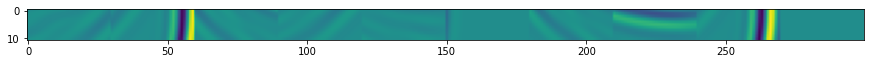

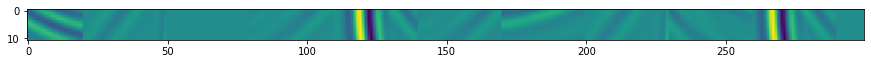

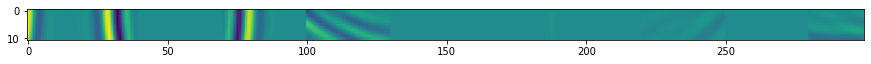

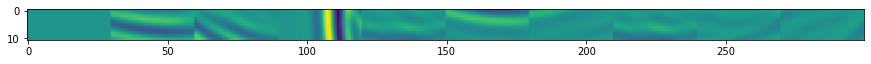

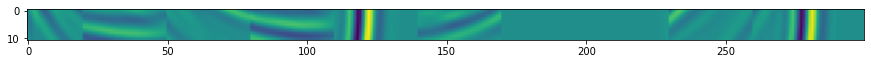

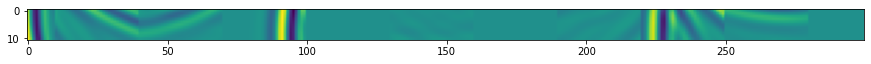

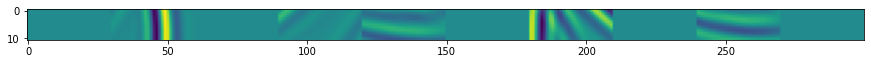

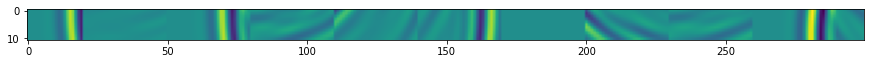

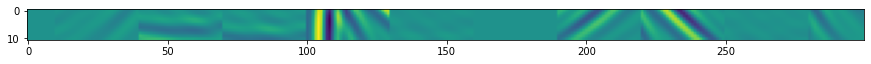

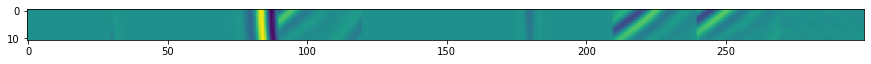

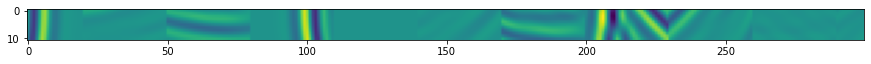

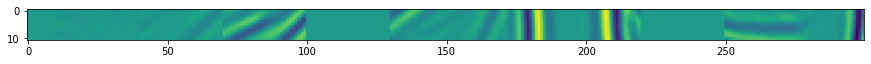

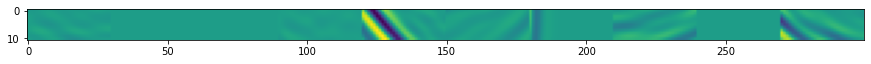

(123990, 23, 115, 1)
(123990, 1, 23, 23, 5) (123990, 11, 1)


In [17]:
# Load dataset created from notebook 'Debias_Data_Cosima'
t_data = np.load('/content/drive/My Drive/sixties_twenty_training_data.npz', allow_pickle=True)

training_data = t_data['arr_0'] # saves the array from t_data file
print(training_data.shape)

# This part reorganises the array into input and label arrays, mainly to help it feed into model with correct shapes
# For training data
train_X = []
train_Y = []

for i in range (len(training_data)):
  train_X.append(training_data[i][0])
  train_Y.append(training_data[i][1])

train_X = np.array(train_X)
train_Y = np.array(train_Y)

print('Training labels')
for i in range(0, len(train_Y), 10000):
  plt.figure(figsize=(15,15))
  plt.imshow(np.rot90(train_Y[i:i+300,].squeeze()))
  plt.show()

# Add axis to training and validation arrays
train_X = train_X[:, :, :, np.newaxis]

print(train_X.shape)

train_X = np.reshape(train_X, (-1,1,23,23,5))

# Check correct shape
print(train_X.shape, train_Y.shape)



In [22]:
# Data must be stored on GPU to use GPU for training
dev = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")

In [19]:
# PyTorch uses tensors
x_train, y_train = map(
    torch.tensor, (train_X, train_Y)
)

x_train, y_train = x_train.to(dev), y_train.to(dev)

print(x_train.shape, y_train.shape)

torch.Size([123990, 1, 23, 23, 5]) torch.Size([123990, 11, 1])


In [27]:
LossOutput = namedtuple("LossOutput", ["relu1_2", "relu2_2", "relu3_3", "relu4_3"])
vgg_model = vgg.vgg16(pretrained=True)
dev = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")
vgg_model.to(dev)
loss_network = LossNetwork(vgg_model)
loss_network.eval()

summary(loss_network, input_size=(3,60,66))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 64, 60, 66]           1,792
              ReLU-2           [-1, 64, 60, 66]               0
            Conv2d-3           [-1, 64, 60, 66]          36,928
              ReLU-4           [-1, 64, 60, 66]               0
         MaxPool2d-5           [-1, 64, 30, 33]               0
            Conv2d-6          [-1, 128, 30, 33]          73,856
              ReLU-7          [-1, 128, 30, 33]               0
            Conv2d-8          [-1, 128, 30, 33]         147,584
              ReLU-9          [-1, 128, 30, 33]               0
        MaxPool2d-10          [-1, 128, 15, 16]               0
           Conv2d-11          [-1, 256, 15, 16]         295,168
             ReLU-12          [-1, 256, 15, 16]               0
           Conv2d-13          [-1, 256, 15, 16]         590,080
             ReLU-14          [-1, 256,

In [21]:
# # CNN model
# cnn = CNN()

# # Store model on GPU for training
# cnn.to(dev)

# # Model summary
# summary(cnn, input_size=(1, 5, 23, 23))

In [ ]:
# Train model with k-fold validation
batch_size = 30
batches = math.ceil(len(train_X)/batch_size)
verbose = 1       # 1: progress bar, 2: without progress bar

k_train_losses, k_val_losses = k_fold_train(x_train, y_train, loss_network, batch_size, batches, verbose)

In [ ]:
# Plot training curves for k folds
for i in range(5):
    plt.plot(k_train_losses[i][:])
    plt.plot(k_val_losses[i][:])
    plt.title('K-fold: {}'.format(i))
    plt.ylabel('loss')
    plt.xlabel('epoch')
    plt.yscale('log')
    plt.legend(['train', 'validation'], loc = 'upper right')
    plt.show()

In [23]:
# Load saved CNN weights
cnn = CNN()
cnn.to(dev)
cnn.load_state_dict(torch.load('/content/drive/My Drive/cnn_state_dict_thirties_content_loss_k0_8'))
cnn.eval()

CNN(
  (conv3d_1): Conv3d(1, 2, kernel_size=(3, 3, 3), stride=(1, 1, 1), padding=(1, 1, 1))
  (sig_1): Sigmoid()
  (bn1): BatchNorm3d(2, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv3d_2): Conv3d(2, 4, kernel_size=(3, 3, 3), stride=(1, 1, 1), padding=(1, 1, 1))
  (sig_2): Sigmoid()
  (bn2): BatchNorm3d(4, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv3d_3): Conv3d(4, 8, kernel_size=(3, 3, 3), stride=(1, 1, 1))
  (sig_3): Sigmoid()
  (bn3): BatchNorm3d(8, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv3d_4): Conv3d(8, 16, kernel_size=(3, 3, 3), stride=(1, 1, 1))
  (sig_4): Sigmoid()
  (bn4): BatchNorm3d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (flat_1): Flatten(start_dim=1, end_dim=-1)
  (lin_1): Linear(in_features=5776, out_features=11, bias=True)
  (lambda_1): Lambda()
)

In [22]:
# Load test dataset
testing_data = np.load('/content/drive/My Drive/sixties_twenty_test_data.npz', allow_pickle=True)
test_data = testing_data['arr_0'] 

# Reorganises the array into input and label arrays, same as for training and validation sets
test_X = []
test_Y = []

for i in range (len(test_data)):
  test_X.append(test_data[i][0])
  test_Y.append(test_data[i][1])

test_X = np.array(test_X)
test_Y = np.array(test_Y)

# Add axis to training and validation arrays
test_X = test_X[:, :, :, np.newaxis]

test_X = np.reshape(test_X, (-1,1,23,23,5))

# Check correct shape
print(test_X.shape, test_Y.shape)


(17760, 1, 23, 23, 5) (17760, 11, 1)


In [23]:
# PyTorch uses tensors
x_test, y_test = map(torch.tensor, (test_X, test_Y))

# Data must be stored on GPU to use GPU for training
dev = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")
x_test, y_test = x_test.to(dev), y_test.to(dev)


print(x_test.shape)

test_ds = TensorDataset(x_test, y_test)

test_dl = DataLoader(test_ds, batch_size=30)

test_dl = WrappedDataLoader(test_dl, preprocess)

torch.Size([17760, 1, 23, 23, 5])


In [24]:
print("Generate predictions using the testing dataset")

predictions = []
batch_loss = 0
batches = 0
loss_func = nrmse_loss

cnn.eval()
for xb, yb in test_dl:
  with torch.no_grad():
      xb = Variable(xb.data, requires_grad=True)

      batch_predictions = cnn(xb)

      predictions.append(batch_predictions.cpu().detach().numpy())

      pred_labels, labels = reshape_for_loss_net(batch_predictions, yb.squeeze(2))

      features_pred_labels = loss_network(pred_labels)
      features_labels = loss_network(labels)

      with torch.no_grad():
          f_labels = features_labels[1].detach()

      batch_loss += loss_func(features_pred_labels[1], f_labels).item()
      batches += 1

test_loss = batch_loss / batches

print('Test RMSE: {}'.format(test_loss))

predictions = np.reshape(predictions, (-1,11))

Generate predictions using the testing dataset
Test RMSE: 0.002161552300094627


Real labels:


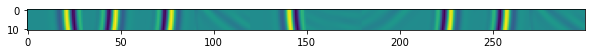

Predicted labels:


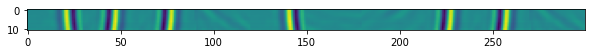

In [25]:
test_Y = test_Y.squeeze()

print("Real labels:")
b = test_Y[300:600, ]
b = np.rot90(b)
plt.figure(figsize=(10,10))
plt.imshow(b)
plt.show()

print("Predicted labels:")
a = predictions[300:600, ]
a = np.rot90(a)
plt.figure(figsize=(10,10))
plt.imshow(a)
plt.show()

In [24]:
# Loads the entire dataset of both blank and wave inputs/labels
norm_inputs = np.load('/content/drive/My Drive/norm_inputs.npz', allow_pickle=True)
norm_labels = np.load('/content/drive/My Drive/norm_labels.npz', allow_pickle=True)

norm_inputs = norm_inputs['arr_0']
print(norm_inputs.shape)

norm_labels = norm_labels['arr_0']
print(norm_labels.shape)

#Append the normalised input images for 1 complete image to a new array
one_img = []
one_lab = []

one_img2 = []
one_lab2 = []
one_img3 = []
one_lab3 = []
one_img4 = []
one_lab4 = []
one_img5 = []
one_lab5 = []

#left column: coloured wave images
# Select time step 475
for i in range (475*270, 476*270, 1):
  one_img.append(norm_inputs[i])
  one_lab.append(norm_labels[i])
print(np.array(one_img).shape, np.array(one_lab).shape)

for i in range (425*270, 426*270, 1):
  one_img2.append(norm_inputs[i])
  one_lab2.append(norm_labels[i])
print(np.array(one_img2).shape, np.array(one_lab2).shape)

for i in range (375*270, 376*270, 1):
  one_img3.append(norm_inputs[i])
  one_lab3.append(norm_labels[i])
print(np.array(one_img3).shape, np.array(one_lab3).shape)

for i in range (325*270, 326*270, 1):
  one_img4.append(norm_inputs[i])
  one_lab4.append(norm_labels[i])
print(np.array(one_img4).shape, np.array(one_lab4).shape)

for i in range (500*270, 501*270, 1):
  one_img5.append(norm_inputs[i])
  one_lab5.append(norm_labels[i])
print(np.array(one_img5).shape, np.array(one_lab5).shape)

one_img = np.array(one_img) # one_img has 1 entire 350x480 image data in it
one_lab = np.array(one_lab)
one_img2 = np.array(one_img2) # one_img has 1 entire 350x480 image data in it
one_lab2 = np.array(one_lab2)
one_img3 = np.array(one_img3) # one_img has 1 entire 350x480 image data in it
one_lab3 = np.array(one_lab3)
one_img4 = np.array(one_img4) # one_img has 1 entire 350x480 image data in it
one_lab4 = np.array(one_lab4)
one_img5 = np.array(one_img5) # one_img has 1 entire 350x480 image data in it
one_lab5 = np.array(one_lab5)

one_img = one_img[:, :, :, np.newaxis]
one_img2 = one_img2[:, :, :, np.newaxis]
one_img3 = one_img3[:, :, :, np.newaxis]
one_img4 = one_img4[:, :, :, np.newaxis]
one_img5 = one_img5[:, :, :, np.newaxis]

one_img = np.reshape(one_img, (-1,1,23,23,5))
one_img2 = np.reshape(one_img2, (-1,1,23,23,5))
one_img3 = np.reshape(one_img3, (-1,1,23,23,5))
one_img4 = np.reshape(one_img4, (-1,1,23,23,5))
one_img5 = np.reshape(one_img5, (-1,1,23,23,5))
print(one_img.shape, one_lab.shape)


(425250, 23, 115)
(425250, 11, 1)
(270, 23, 115) (270, 11, 1)
(270, 23, 115) (270, 11, 1)
(270, 23, 115) (270, 11, 1)
(270, 23, 115) (270, 11, 1)
(270, 23, 115) (270, 11, 1)
(270, 1, 23, 23, 5) (270, 11, 1)


In [25]:
# PyTorch uses tensors
one_img, one_lab = map(torch.tensor, (one_img, one_lab))
one_img2, one_lab2 = map(torch.tensor, (one_img2, one_lab2))
one_img3, one_lab3 = map(torch.tensor, (one_img3, one_lab3))
one_img4, one_lab4 = map(torch.tensor, (one_img4, one_lab4))
one_img5, one_lab5 = map(torch.tensor, (one_img5, one_lab5))


# Data must be stored on GPU to use GPU for training
dev = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")
one_img, one_lab = one_img.to(dev), one_lab.to(dev)
one_img2, one_lab2 = one_img2.to(dev), one_lab2.to(dev)
one_img3, one_lab3 = one_img3.to(dev), one_lab3.to(dev)
one_img4, one_lab4 = one_img4.to(dev), one_lab4.to(dev)
one_img5, one_lab5 = one_img5.to(dev), one_lab5.to(dev)

one_ds = TensorDataset(one_img, one_lab)
one_ds2 = TensorDataset(one_img2, one_lab2)
one_ds3 = TensorDataset(one_img3, one_lab3)
one_ds4 = TensorDataset(one_img4, one_lab4)
one_ds5 = TensorDataset(one_img5, one_lab5)


one_dl = DataLoader(one_ds, batch_size=30)
one_dl2 = DataLoader(one_ds2, batch_size=30)
one_dl3 = DataLoader(one_ds3, batch_size=30)
one_dl4 = DataLoader(one_ds4, batch_size=30)
one_dl5 = DataLoader(one_ds5, batch_size=30)

one_dl = WrappedDataLoader(one_dl, preprocess)
one_dl2 = WrappedDataLoader(one_dl2, preprocess)
one_dl3 = WrappedDataLoader(one_dl3, preprocess)
one_dl4 = WrappedDataLoader(one_dl4, preprocess)
one_dl5 = WrappedDataLoader(one_dl5, preprocess)

In [32]:
print("Generate predictions for 1 set of borders")

predictions2 = []
predictions3 = []
predictions4 = []
predictions5 = []
predictions6 = []

cnn.eval()

loss_func = nrmse_loss

batch_loss = 0
batches = 0
for xb, yb in one_dl:
  with torch.no_grad():
      xb = Variable(xb.data, requires_grad=True)

      batch_predictions = cnn(xb)

      predictions2.append(batch_predictions.cpu().detach().numpy())

      pred_labels, labels = reshape_for_loss_net(batch_predictions, yb.squeeze(2))

      features_pred_labels = loss_network(pred_labels)
      features_labels = loss_network(labels)

      with torch.no_grad():
          f_labels = features_labels[1].detach()

      batch_loss += loss_func(features_pred_labels[1], f_labels).item()
      batches += 1

image_loss = batch_loss / batches

print('Image RMSE: {}'.format(image_loss))

predictions2 = np.reshape(predictions2, (-1,11))

batch_loss = 0
batches = 0
for xb, yb in one_dl2:
  with torch.no_grad():
      xb = Variable(xb.data, requires_grad=True)

      batch_predictions = cnn(xb)

      predictions3.append(batch_predictions.cpu().detach().numpy())

      pred_labels, labels = reshape_for_loss_net(batch_predictions, yb.squeeze(2))

      features_pred_labels = loss_network(pred_labels)
      features_labels = loss_network(labels)

      with torch.no_grad():
          f_labels = features_labels[1].detach()

      batch_loss += loss_func(features_pred_labels[1], f_labels).item()
      batches += 1

image_loss = batch_loss / batches

print('Image RMSE: {}'.format(image_loss))

predictions3 = np.reshape(predictions3, (-1,11))

batch_loss = 0
batches = 0
for xb, yb in one_dl3:
  with torch.no_grad():
      xb = Variable(xb.data, requires_grad=True)

      batch_predictions = cnn(xb)

      predictions4.append(batch_predictions.cpu().detach().numpy())

      pred_labels, labels = reshape_for_loss_net(batch_predictions, yb.squeeze(2))

      features_pred_labels = loss_network(pred_labels)
      features_labels = loss_network(labels)

      with torch.no_grad():
          f_labels = features_labels[1].detach()

      batch_loss += loss_func(features_pred_labels[1], f_labels).item()
      batches += 1

image_loss = batch_loss / batches

print('Image RMSE: {}'.format(image_loss))

predictions4 = np.reshape(predictions4, (-1,11))

batch_loss = 0
batches = 0
for xb, yb in one_dl4:
  with torch.no_grad():
      xb = Variable(xb.data, requires_grad=True)

      batch_predictions = cnn(xb)

      predictions5.append(batch_predictions.cpu().detach().numpy())

      pred_labels, labels = reshape_for_loss_net(batch_predictions, yb.squeeze(2))

      features_pred_labels = loss_network(pred_labels)
      features_labels = loss_network(labels)

      with torch.no_grad():
          f_labels = features_labels[1].detach()

      batch_loss += loss_func(features_pred_labels[1], f_labels).item()
      batches += 1

image_loss = batch_loss / batches

print('Image RMSE: {}'.format(image_loss))

predictions5 = np.reshape(predictions5, (-1,11))

batch_loss = 0
batches = 0
for xb, yb in one_dl5:
  with torch.no_grad():
      xb = Variable(xb.data, requires_grad=True)

      batch_predictions = cnn(xb)

      predictions6.append(batch_predictions.cpu().detach().numpy())

      pred_labels, labels = reshape_for_loss_net(batch_predictions, yb.squeeze(2))

      features_pred_labels = loss_network(pred_labels)
      features_labels = loss_network(labels)

      with torch.no_grad():
          f_labels = features_labels[1].detach()

      batch_loss += loss_func(features_pred_labels[1], f_labels).item()
      batches += 1

image_loss = batch_loss / batches

print('Image RMSE: {}'.format(image_loss))

predictions6 = np.reshape(predictions6, (-1,11))



Generate predictions for 1 set of borders
Image RMSE: 0.004338498330778546
Image RMSE: 0.0030216543366097743
Image RMSE: 0.002173794795655542
Image RMSE: 0.004316551882463197
Image RMSE: 0.0033183607479764354


In [33]:
one_img = one_img.cpu().detach().numpy()
one_lab = one_lab.cpu().detach().numpy()
one_img2 = one_img2.cpu().detach().numpy()
one_lab2 = one_lab2.cpu().detach().numpy()
one_img3 = one_img3.cpu().detach().numpy()
one_lab3 = one_lab3.cpu().detach().numpy()
one_img4 = one_img4.cpu().detach().numpy()
one_lab4 = one_lab4.cpu().detach().numpy()
one_img5 = one_img5.cpu().detach().numpy()
one_lab5 = one_lab5.cpu().detach().numpy()

AttributeError: ignored

In [34]:
one_lab = one_lab.squeeze()
one_lab2 = one_lab2.squeeze()
one_lab3 = one_lab3.squeeze()
one_lab4 = one_lab4.squeeze()
one_lab5 = one_lab5.squeeze()

Timestep: 325
Real Left Column:


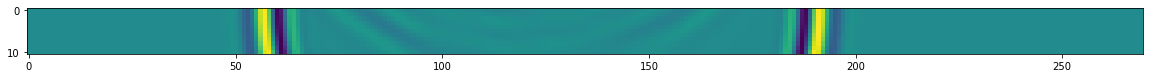

Predicted Left Column:


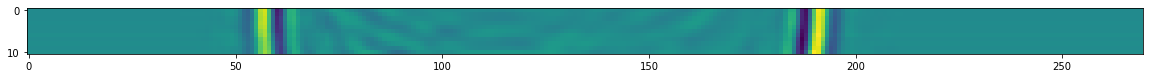

Timestep: 375
Real Left Column:


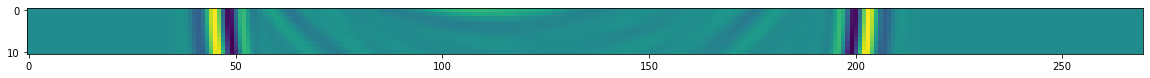

Predicted Left Column:


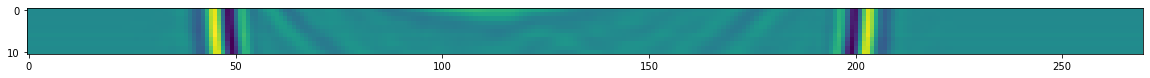

Timestep: 425
Real Left Column:


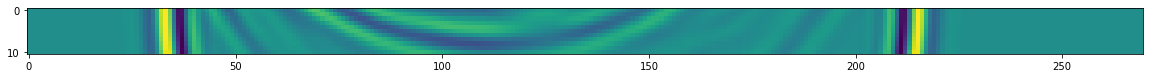

Predicted Left Column:


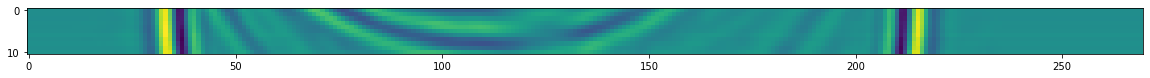

Timestep: 475
Real Left Column:


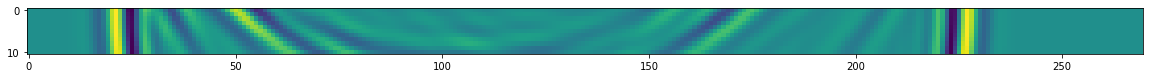

Predicted Left Column:


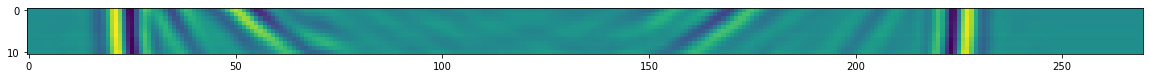

Timestep: 500
Real Left Column:


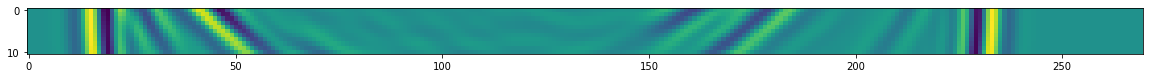

Predicted Left Column:


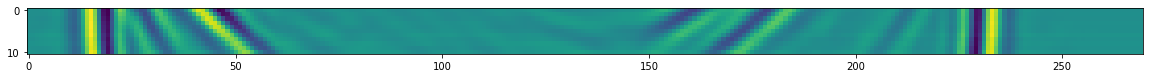

In [35]:
print('Timestep: 325')
print("Real Left Column:")
plt.figure(figsize=(20,20))
g = one_lab4[:, :]
g = np.rot90(g)
plt.imshow(g)
plt.show()
print("Predicted Left Column:")
plt.figure(figsize=(20,20))
e = predictions5[:, :]
e = np.rot90(e)
plt.imshow(e)
plt.show()

print('Timestep: 375')
print("Real Left Column:")
plt.figure(figsize=(20,20))
g = one_lab3[:, :]
g = np.rot90(g)
plt.imshow(g)
plt.show()
print("Predicted Left Column:")
plt.figure(figsize=(20,20))
e = predictions4[:, :]
e = np.rot90(e)
plt.imshow(e)
plt.show()

print('Timestep: 425')
print("Real Left Column:")
plt.figure(figsize=(20,20))
g = one_lab2[:, :]
g = np.rot90(g)
plt.imshow(g)
plt.show()
print("Predicted Left Column:")
plt.figure(figsize=(20,20))
e = predictions3[:, :]
e = np.rot90(e)
plt.imshow(e)
plt.show()

print('Timestep: 475')
print("Real Left Column:")
plt.figure(figsize=(20,20))
g = one_lab[:, :]
g = np.rot90(g)
plt.imshow(g)
plt.show()
print("Predicted Left Column:")
plt.figure(figsize=(20,20))
e = predictions2[:, :]
e = np.rot90(e)
plt.imshow(e)
plt.show()

print('Timestep: 500')
print("Real Left Column:")
plt.figure(figsize=(20,20))
g = one_lab5[:, :]
g = np.rot90(g)
plt.imshow(g)
plt.show()
print("Predicted Left Column:")
plt.figure(figsize=(20,20))
e = predictions6[:, :]
e = np.rot90(e)
plt.imshow(e)
plt.show()

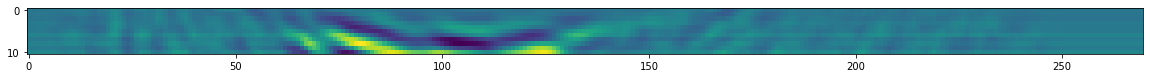

In [36]:
# Checking the differences between predicted and real images
plt.figure(figsize=(20,3))
diff_blank = predictions2 - one_lab
diff_blank = np.rot90(diff_blank)
plt.imshow(diff_blank)
plt.show()

In [37]:
basedata = np.load('/content/drive/My Drive/basedata.npz')['a']

In [38]:
pred_left425 = predictions3
real_left425 = one_lab2

pred_left475 = predictions2
real_left475 = one_lab

print(pred_left425.shape)

(270, 11)


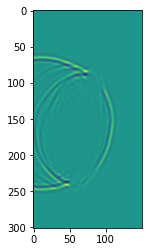

In [39]:
# image from one time step
image = basedata[425]
roi = image[249:751, 314:686]
roi = roi[115-20:385+11, :150]

roi = (roi - np.min(basedata)) / (np.max(basedata) - np.min(basedata))
plt.imshow(roi)
plt.show()

In [40]:
# Create empty array of desired rectangle size
pred_image_out425 = np.zeros((270, 150))
real_image_out425 = np.zeros((270, 150))
pred_image_out475 = np.zeros((270, 150))
real_image_out475 = np.zeros((270, 150))

(270, 11)


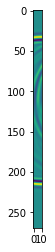

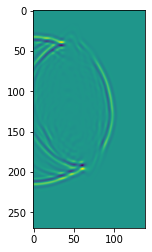

In [47]:
#left column labels

label_left = []
image_right = []

for i in range(270):  #create the location span of the lines
  line_label = roi[269+11-i:270+11-i, 0:11] #gets the line in terms of i
  line_label_T = np.rot90(line_label, 3)
  label_left.append(line_label_T)

  rest_of_image = roi[269+11-i:270+11-i, 11:]
  rest_of_image = np.rot90(rest_of_image, 3)
  image_right.append(rest_of_image)


labels_array = np.zeros((270,11))
image_array = np.zeros((270,139))
for i in range(270):
  labels_array[i,:] = np.squeeze(label_left[i])
  image_array[i,:] = np.squeeze(image_right[i])


print(labels_array.shape)

plt.imshow(labels_array)
plt.show()
plt.imshow(image_array)

In [43]:
pred_image_out425[:, 0:11] = pred_left425
pred_image_out425[:, 11:] = image_array
real_image_out425[:, 0:11] = real_left425
real_image_out425[:, 11:] = image_array

In [44]:
pred_image_out425 = pred_image_out425[:250, :70]
real_image_out425 = real_image_out425[:250, :70]

Timestep 425


[Text(0, 0, '11')]

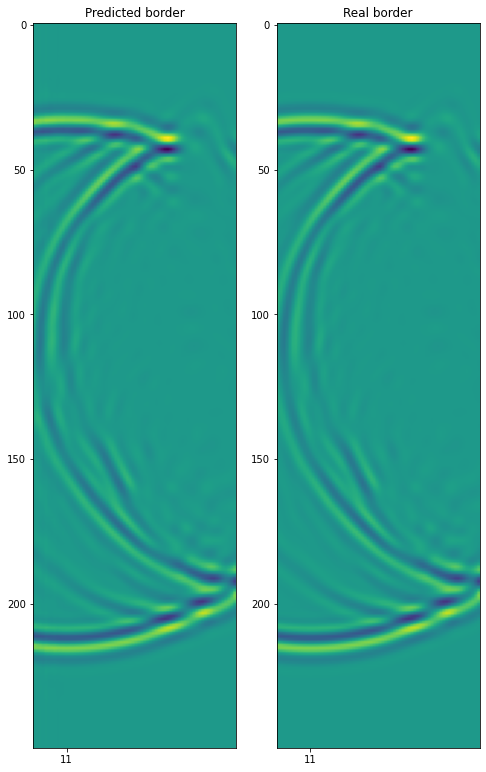

In [45]:
# Plot images

print('Timestep 425')

fig, ax = plt.subplots(1, 2, figsize=(8,15))
ax[0].imshow(pred_image_out425)
ax[1].imshow(real_image_out425)
ax[0].set_title('Predicted border')
ax[1].set_title('Real border')
ax[0].set_xticks([11])
ax[0].set_xticklabels(['11'])
ax[1].set_xticks([11])
ax[1].set_xticklabels(['11'])

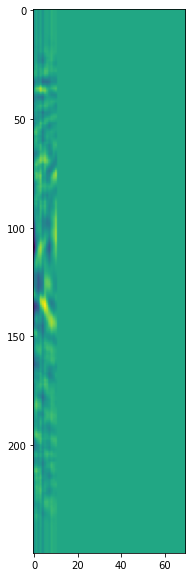

In [46]:
plt.figure(figsize=(10,10))
plt.imshow(real_image_out425-pred_image_out425)